<h2><center>Starter Code for Docking ISS</center></h2>

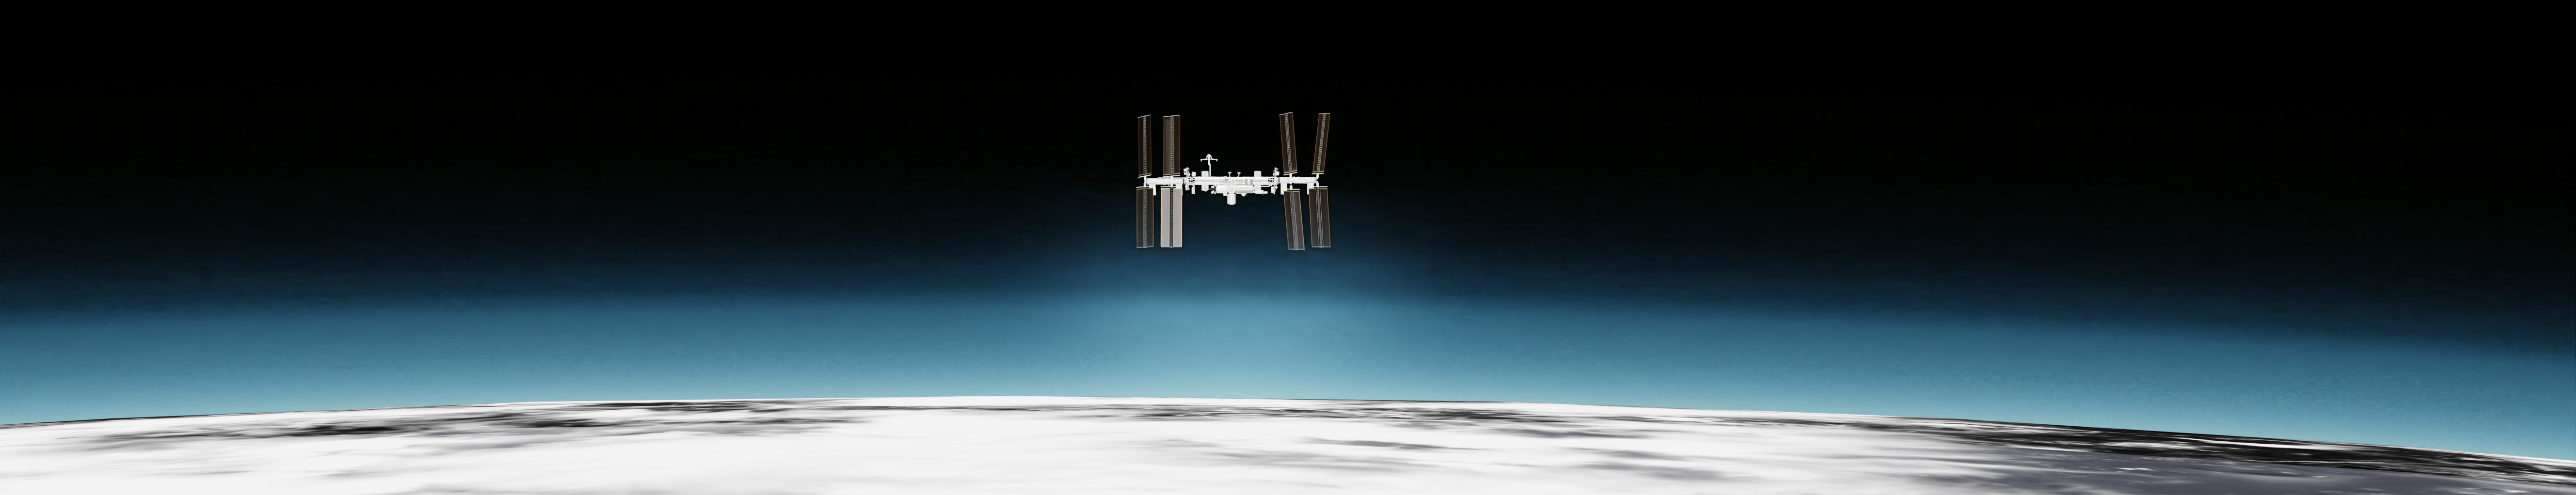
### What we are going to Learn

  - Image Classification using Pytorch
  - Creating & Training multi output predictions using pretrained resnet model   
  - Testing and Submitting the Results to the Challenge. 

**Note : Create a copy of the notebook and use the copy for submission. Go to *File > Save a Copy in Drive* to create a new copy**

# Setting up Environment

### Downloading Dataset

So we will first need to download the python library by AIcrowd that will allow us to download the dataset by just inputting the API key. 

In [1]:
!pip install aicrowd-cli

%load_ext aicrowd.magic

     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 208 kB 23.6 MB/s 
     |████████████████████████████████| 170 kB 23.7 MB/s 
     |████████████████████████████████| 76 kB 6.8 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 51 kB 10.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have req

In [2]:
%aicrowd login --api-key c18a6c4b759fa2df29481af274df6942

API Key valid
Saved API Key successfully!


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c docking-iss -o data

submission.csv:   0%|          | 0.00/267k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/75.1M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/217k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/150M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

In [4]:
# Unzipping the files
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

### Downloading & Importing Libraries

Here we are going to use PyTorch to do our multioutput tasks, while [PyTorch](https://pytorch.org/) is really popular deep learning model, for those who are new to PyTorch, pytorch is an open source Deep Learning Library thay helps in creating, training Deep Learning Models, and much more. 

We are also going to use [pretrainedmodels.pytorch](https://github.com/Cadene/pretrained-models.pytorch)  which provides tons of pretrained deep learning models, such as resnets, vgg or efficientnets.  

In [5]:
# PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

# Pretrained Models
import torchvision.models as models
!pip install torchextractor

# Reading Dataset & Visualizations
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

# Misc
import os
from tqdm import trange
from tqdm.notebook import tqdm
import random

# Using GPU for training if GPU is detected, else, CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def seed_everything(seed):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

seed_everything(1)

Make Sure your GPU is enabled by going in tab **Runtime** > **Change Runtime Type** > **Hardware Accelerator** > **GPU**

# Training phase ⚙️

## Reading Dataset

Reading the necessary files to train, validation & submit our results! 

In [7]:
# Reading the training dataset
train_df = pd.read_csv("data/train.csv")
train_df

ImageID  distance    location
0           0       351  [215, 158]
1           1       372  [228, 269]
2           2       488  [255, 386]
3           3       308  [306, 426]
4           4        67  [248, 338]
...       ...       ...         ...
9995     9995       409  [231, 386]
9996     9996       307  [280, 103]
9997     9997       270  [280, 490]
9998     9998       390  [228, 110]
9999     9999       195  [286, 464]

[10000 rows x 3 columns]

## Data Visualization

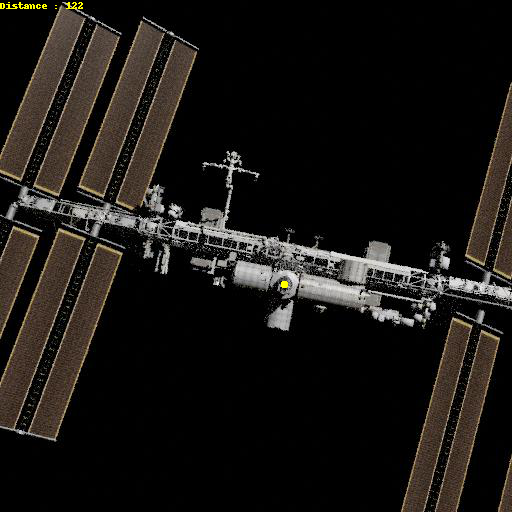

In [8]:
# Reading a ramdom sample
sample_index = random.randint(0, train_df.shape[0]-1)

# Reading the image
img = Image.open(f"data/train/{train_df['ImageID'][sample_index]}.jpg")

# Getting the distance and location of the specific image
distance = train_df['distance'][sample_index]
location = eval(train_df['location'][sample_index])

# Drawing the location and the distance
draw = ImageDraw.Draw(img)
x, y, r = location[0], location[1], 3
points = (x-r, y-r, x+r, y+r)
draw.ellipse(points, "yellow")
draw.text((0, 0),f"Distance : {distance}","yellow")

img

## Creating the Dataset

In [9]:
import torchvision.transforms as transforms

class ISSDataset(Dataset):

  def __init__(self, img_directory, csv_path=None, train=True):
    
    # Images directory and reading corrospoding csv
    self.img_directory = img_directory
    self.train = train
    self.data = pd.read_csv(csv_path)

  def __len__(self):
    return len(os.listdir(self.img_directory))

  def __getitem__(self, idx):

    img_id = self.data['ImageID'][idx]

    # Reading the image
    img_path = os.path.join(self.img_directory, f"{img_id}.jpg")
    img = Image.open(img_path)
    trans = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    img = trans(img)

    # If the dataset is set to train
    if self.train == True:
      
      # Reading the labels
      distance = self.data[self.data['ImageID'] == img_id]['distance'].values[0]
      location = eval(self.data[self.data['ImageID'] == img_id]['location'].values[0])

      label = [distance, location[0], location[1]]


      return img, label
    
    # If dataset is set to testing data
    else:

      return img, img_id

In [10]:
# Reading the training dataset
train_iss_dataset = ISSDataset(csv_path="data/train.csv", img_directory="data/train/")
train_dataset = DataLoader(train_iss_dataset, batch_size=8, shuffle=True)

# Reading the validation dataset
val_iss_dataset = ISSDataset(csv_path="data/val.csv", img_directory="data/val/")
val_dataset = DataLoader(val_iss_dataset, batch_size=8, shuffle=True)

In [11]:
# Going through a sample of the the dataset
feature, labels = next(iter(train_dataset))

[tensor([461, 361, 144, 163, 109, 411, 274, 184]),
 tensor([258, 240, 302, 279, 261, 304, 307, 203]),
 tensor([342, 307, 162, 247, 186, 408,  87, 450])]

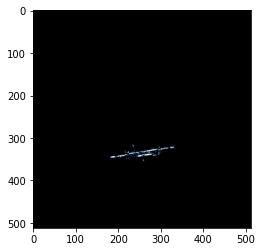

In [12]:
# Showing the image with label
img = np.moveaxis(feature[0].numpy(), 0, -1)
plt.imshow(img)
labels

## Creating the Model

Using a Pretrained Resnet18 model and adding three fully connected layers to predict - 
* Distance
* Location in X axis
* Location in Y axis

In [13]:
import torchextractor as tx

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    # Using a pretrained mdoel
    self.model = models.resnet34(pretrained=True)
    self.ex_model = tx.Extractor(self.model, ["layer4.2.bn2"])

    # Creating 3 fully connected layers 
    self.distance_fc = nn.Linear(512, 1)
    self.location_fc_x = nn.Linear(512, 1)
    self.location_fc_y = nn.Linear(512, 1)

  # Takingt the image and predicting the labels 
  def forward(self, image):  
    batch_size = image.shape[0]
    output, feature = self.ex_model(image)
    x = F.adaptive_avg_pool2d(feature["layer4.2.bn2"], 1).reshape(batch_size, -1)
    distance = self.distance_fc(x)
    location_x = self.location_fc_x(x)
    location_y = self.location_fc_y(x)

    return distance, location_x, location_y

model = Model()
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [14]:
# Sample Predictions
model.to(device)
sample_predictions = model(feature.to(device))
sample_predictions

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(tensor([[-0.7092],
         [-0.7338],
         [-1.1216],
         [-0.8518],
         [-0.9462],
         [-0.4280],
         [-0.6472],
         [-0.7347]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.3866],
         [ 0.3984],
         [ 0.0942],
         [ 0.0764],
         [ 0.5746],
         [-0.1033],
         [ 0.2729],
         [-0.0544]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[-0.1651],
         [-0.3485],
         [-0.1941],
         [-0.4759],
         [ 0.1668],
         [-0.3624],
         [-0.3289],
         [-0.4561]], device='cuda:0', grad_fn=<AddmmBackward>))

## Setting up Parameters

Here we will be setting up few parameters including Loss, Optimizer, Learning Rate and function for the trainign

In [15]:
# Loss
loss_function = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [18]:
# Training Function 
def train(train_dataloader, val_dataloader, model, loss_function, optimizer, scheduler, epochs=1, early_stopping=3):

  # Using GPU if GPU is detected
  model = model.to(device)
  best_val = float('inf')
  prev_loss = float('inf')
  counter = 0

  model.train()
  for epoch in range(epochs):
    losses = []
    # train
    print(f"Training epoch {epoch}")
    pbar = tqdm(train_dataloader) # Creating a progress bar
    for batch, (X, y) in enumerate(train_dataloader):
      
      # Ground truth
      y = [i.to(torch.float32).to(device).unsqueeze(1) for i in y]

      # Predictions
      pred = model(X.to(device))
      pred = [i.to(torch.float32)  for i in pred]

      # Calulating total loss for 3 predictions
      loss = loss_function(y[0], pred[0]) + loss_function(y[1], pred[1]) + loss_function(y[2], pred[2])

      # Doing backpropagation if train is set to true
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
      optimizer.step()

      # Updating the progress bar
      pbar.set_description(f"Batch : {batch} Loss : {loss.item()}")
      losses.append(loss.item())
      pbar.update(1)
    
    scheduler.step()
    avg_loss = sum(losses) / len(losses)
    print(avg_loss)

    if os.path.exists('last.pt'):
      os.remove('last.pt')
    torch.save(model.state_dict(), 'last.pt')

    # eval
    model.eval()
    losses = []
    print(f"Evaluating epoch {epoch}")
    pbar = tqdm(val_dataloader) # Creating a progress bar
    for batch, (X, y) in enumerate(val_dataloader):
      # Ground truth
      y = [i.to(torch.float32).to(device).unsqueeze(1) for i in y]

      # Predictions
      pred = model(X.to(device))
      pred = [i.to(torch.float32)  for i in pred]

      # Calulating total loss for 3 predictions
      loss = loss_function(y[0], pred[0]) + loss_function(y[1], pred[1]) + loss_function(y[2], pred[2])

      # Updating the progress bar
      pbar.set_description(f"Batch : {batch} Loss : {loss.item()}")
      losses.append(loss.item())
      pbar.update(1)

    avg_loss = sum(losses) / len(losses)
    print(avg_loss)

    # save best
    if avg_loss < best_val:
      if os.path.exists('best.pt'):
        os.remove('best.pt')
      print(f"Saving epoch {epoch} to best")
      torch.save(model.state_dict(), 'best.pt')
      best_val = avg_loss

    # early stopping
    if avg_loss < prev_loss:
      counter = 0
    else:
      counter += 1
    if counter == early_stopping:
      print('Early stopping')
      return
    prev_loss = avg_loss
    print()

## Training the Model
And there we go! It's finally the time to start the training!

In [19]:
train(train_dataloader=train_dataset, val_dataloader=val_dataset, model=model, loss_function=loss_function, optimizer=optimizer, scheduler=scheduler, epochs=30, early_stopping=3)

Training epoch 0


  0%|          | 0/1250 [00:00<?, ?it/s]

3036.066275415039
Evaluating epoch 0


  0%|          | 0/125 [00:00<?, ?it/s]

1254.621623046875
Saving epoch 0 to best

Training epoch 1


  0%|          | 0/1250 [00:00<?, ?it/s]

5815.499087322998
Evaluating epoch 1


  0%|          | 0/125 [00:00<?, ?it/s]

327.3456998291016
Saving epoch 1 to best

Training epoch 2


  0%|          | 0/1250 [00:00<?, ?it/s]

202.0453300994873
Evaluating epoch 2


  0%|          | 0/125 [00:00<?, ?it/s]

104.13206774902343
Saving epoch 2 to best

Training epoch 3


  0%|          | 0/1250 [00:00<?, ?it/s]

118.17038867645263
Evaluating epoch 3


  0%|          | 0/125 [00:00<?, ?it/s]

212.22201495361327

Training epoch 4


  0%|          | 0/1250 [00:00<?, ?it/s]

84.92634802322388
Evaluating epoch 4


  0%|          | 0/125 [00:00<?, ?it/s]

56.83449235534668
Saving epoch 4 to best

Training epoch 5


  0%|          | 0/1250 [00:00<?, ?it/s]

207.66382970314027
Evaluating epoch 5


  0%|          | 0/125 [00:00<?, ?it/s]

44.485612213134765
Saving epoch 5 to best

Training epoch 6


  0%|          | 0/1250 [00:00<?, ?it/s]

58.05369370117187
Evaluating epoch 6


  0%|          | 0/125 [00:00<?, ?it/s]

47.19966595458985

Training epoch 7


  0%|          | 0/1250 [00:00<?, ?it/s]

49.24820898704529
Evaluating epoch 7


  0%|          | 0/125 [00:00<?, ?it/s]

44.56990463256836

Training epoch 8


  0%|          | 0/1250 [00:00<?, ?it/s]

40.90301960372925
Evaluating epoch 8


  0%|          | 0/125 [00:00<?, ?it/s]

33.917026329040525
Saving epoch 8 to best

Training epoch 9


  0%|          | 0/1250 [00:00<?, ?it/s]

72.6444462059021
Evaluating epoch 9


  0%|          | 0/125 [00:00<?, ?it/s]

29.96908671951294
Saving epoch 9 to best

Training epoch 10


  0%|          | 0/1250 [00:00<?, ?it/s]

5.963173244476319
Evaluating epoch 10


  0%|          | 0/125 [00:00<?, ?it/s]

6.6478283405303955
Saving epoch 10 to best

Training epoch 11


  0%|          | 0/1250 [00:00<?, ?it/s]

4.069909118080139
Evaluating epoch 11


  0%|          | 0/125 [00:00<?, ?it/s]

6.054769064903259
Saving epoch 11 to best

Training epoch 12


  0%|          | 0/1250 [00:00<?, ?it/s]

3.3674689956188204
Evaluating epoch 12


  0%|          | 0/125 [00:00<?, ?it/s]

4.560097573280334
Saving epoch 12 to best

Training epoch 13


  0%|          | 0/1250 [00:00<?, ?it/s]

2.866679392242432
Evaluating epoch 13


  0%|          | 0/125 [00:00<?, ?it/s]

4.190253877639771
Saving epoch 13 to best

Training epoch 14


  0%|          | 0/1250 [00:00<?, ?it/s]

2.5828966095924377
Evaluating epoch 14


  0%|          | 0/125 [00:00<?, ?it/s]

4.5311976928710935

Training epoch 15


  0%|          | 0/1250 [00:00<?, ?it/s]

2.2982003667354585
Evaluating epoch 15


  0%|          | 0/125 [00:00<?, ?it/s]

4.079695592880249
Saving epoch 15 to best

Training epoch 16


  0%|          | 0/1250 [00:00<?, ?it/s]

2.0819439651966096
Evaluating epoch 16


  0%|          | 0/125 [00:00<?, ?it/s]

3.603912486553192
Saving epoch 16 to best

Training epoch 17


  0%|          | 0/1250 [00:00<?, ?it/s]

1.859853053331375
Evaluating epoch 17


  0%|          | 0/125 [00:00<?, ?it/s]

3.1436537284851074
Saving epoch 17 to best

Training epoch 18


  0%|          | 0/1250 [00:00<?, ?it/s]

1.687965344119072
Evaluating epoch 18


  0%|          | 0/125 [00:00<?, ?it/s]

3.65362727022171

Training epoch 19


  0%|          | 0/1250 [00:00<?, ?it/s]

1.549966452407837
Evaluating epoch 19


  0%|          | 0/125 [00:00<?, ?it/s]

3.218546859741211

Training epoch 20


  0%|          | 0/1250 [00:00<?, ?it/s]

0.8204601719141007
Evaluating epoch 20


  0%|          | 0/125 [00:00<?, ?it/s]

2.566571607589722
Saving epoch 20 to best

Training epoch 21


  0%|          | 0/1250 [00:00<?, ?it/s]

0.757522131729126
Evaluating epoch 21


  0%|          | 0/125 [00:00<?, ?it/s]

2.559755177497864
Saving epoch 21 to best

Training epoch 22


  0%|          | 0/1250 [00:00<?, ?it/s]

0.7355985894680023
Evaluating epoch 22


  0%|          | 0/125 [00:00<?, ?it/s]

2.569019025325775

Training epoch 23


  0%|          | 0/1250 [00:00<?, ?it/s]

0.7177669263601303
Evaluating epoch 23


  0%|          | 0/125 [00:00<?, ?it/s]

2.540828350543976
Saving epoch 23 to best

Training epoch 24


  0%|          | 0/1250 [00:00<?, ?it/s]

0.6965162041902542
Evaluating epoch 24


  0%|          | 0/125 [00:00<?, ?it/s]

2.533842855453491
Saving epoch 24 to best

Training epoch 25


  0%|          | 0/1250 [00:00<?, ?it/s]

0.6810516425132751
Evaluating epoch 25


  0%|          | 0/125 [00:00<?, ?it/s]

2.555759622812271

Training epoch 26


  0%|          | 0/1250 [00:00<?, ?it/s]

0.6699236445784569
Evaluating epoch 26


  0%|          | 0/125 [00:00<?, ?it/s]

2.5762552161216736

Training epoch 27


  0%|          | 0/1250 [00:00<?, ?it/s]

0.654273344528675
Evaluating epoch 27


  0%|          | 0/125 [00:00<?, ?it/s]

2.4624039311408996
Saving epoch 27 to best

Training epoch 28


  0%|          | 0/1250 [00:00<?, ?it/s]

0.6417448691606522
Evaluating epoch 28


  0%|          | 0/125 [00:00<?, ?it/s]

2.4823058276176453

Training epoch 29


  0%|          | 0/1250 [00:00<?, ?it/s]

0.6341520946502686
Evaluating epoch 29


  0%|          | 0/125 [00:00<?, ?it/s]

2.462458078145981



In [20]:
model.load_state_dict(torch.load("best.pt"))
model.eval()

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [21]:
losses = []
for batch, (X, y) in enumerate(val_dataset):
  # Ground truth
  y = [i.to(torch.float32).to(device).unsqueeze(1) for i in y]

  # Predictions
  pred = model(X.to(device))
  pred = [i.to(torch.float32)  for i in pred]

  # Calulating total loss for 3 predictions
  loss = loss_function(y[0], pred[0]) + loss_function(y[1], pred[1]) + loss_function(y[2], pred[2])
  losses.append(loss.item())

avg_loss = sum(losses) / len(losses)
print(avg_loss)

2.462403904914856


# Submitting Results 📄

Okay, this is the last section 😌 , let's get out testing results from the model real quick and submit our prediction directly using AIcrowd CLI

## Reading the Test Dataset

In [22]:
test_dataset = ISSDataset(img_directory="data/test/", csv_path="data/submission.csv", train=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [23]:
# Function to take the dataset & model and return the predictions for all samples
def test(dataloader, model):

  # Loss containing predictions
  distances = []
  locations = []
  imageids = []

  model = model.to(device)

  # Going through each batch  
  for batch, (X, img_id) in tqdm(enumerate(dataloader)):

    # Getting the predictions
    pred = model(X.to(device))

    # Adding the distance
    distance = pred[0].cpu().detach().tolist()
    distances.extend([*distance])
    
    # Adding the Locations 
    location_x = pred[1].cpu().detach().tolist()
    location_y = pred[2].cpu().detach().tolist()
    location = [[x[0], y[0]]  for x, y in zip(location_x, location_y)]
    locations.extend(location)

    imageids.extend([*img_id.tolist()])

  return imageids, [d[0] for d in distances], locations

In [24]:
# Running the inference
imageids, distances, locations = test(test_dataloader, model)

0it [00:00, ?it/s]

In [25]:
# Adding the predictions to the submission.csv 
test_dataset.data.ImageID = imageids
test_dataset.data.distance = distances
test_dataset.data.location = locations
test_dataset.data

ImageID    distance                                  location
0           0  334.811279   [263.3127746582031, 198.77975463867188]
1           1  474.422394   [318.26129150390625, 92.25271606445312]
2           2  449.483978    [224.6585235595703, 474.1216735839844]
3           3  123.270569   [285.2651672363281, 474.11358642578125]
4           4  156.097122   [231.49708557128906, 429.7414855957031]
...       ...         ...                                       ...
4995     4995  445.806519  [230.94476318359375, 202.99192810058594]
4996     4996  351.226746    [260.89678955078125, 496.874755859375]
4997     4997  382.366364   [235.5128936767578, 482.14031982421875]
4998     4998   66.930283   [317.71600341796875, 347.5683898925781]
4999     4999  214.803085    [264.1017761230469, 341.0007629394531]

[5000 rows x 3 columns]


**Note : Please make sure that there should be filename `submission.csv` in `assets` folder before submitting it**

In [26]:
# Saving the submission.csv in the assets folder 
!rm -rf assets
!mkdir assets

test_dataset.data.to_csv(os.path.join("assets", "submission.csv"), index=False)

## Uploading the Results

Usage: aicrowd notebook submit 
           [OPTIONS]

  Submit the notebook to AIcrowd

Options:
  -c, --challenge TEXT      Challenge to submit
                            the file for
                            [required]

  --description TEXT        Description for the
                            submission

  -a, --assets-dir TEXT     Path to assets dir
                            [required]

  -o, --output TEXT         Output file
  -n, --notebook-name TEXT  Name of the notebook
                            to use

  --no-verify               Skip submission
                            verification

  --dry-run                 Verify submission but
                            don't submit

  --help                    Show this message and
                            exit.


Usage: aicrowd notebook submit 
           [OPTIONS]
Try 'aicrowd notebook submit --help' for help.

Error: no such option: -v


In [28]:
!cp best.pt drive/MyDrive

> Don't be shy to ask question related to any errors you are getting or doubts in any part of this notebook in [discussion forum](https://www.aicrowd.com/challenges/ai-blitz-10/problems/docking-iss/discussion) or in [AIcrowd Discord sever](https://discord.gg/T6uZSWBMSZ), AIcrew will be happy to help you :)

Also, wanna give us your valuable feedback for next blitz or wanna work with us creating blitz challanges ? Let us know! 